# Implementación del modelo spsuma en un simulador paralelo

#### Se representa como:
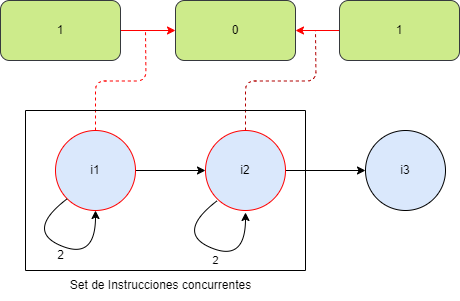

*numero de virus puede cambiar


In [1]:
import math
import random
from numba import cuda,jit,njit
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import time
import matplotlib.pyplot as plt   
import sys
import os
sys.path.append("/home/servelgar/tfg-cuda/vm/examples")
sys.path.append("/home/servelgar/tfg-cuda/vm/src")
sys.path.append("/home/servelgar/tfg-cuda/vm/tests")
print(sys.path)
from basicprobabilistic import basicprobabilistic
from spsuma import spsuma

/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:45: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/python3.9/site-packages/numba/cuda/random.py:71: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(forceobj=_forceobj, looplift=_looplift)
/home/servelgar/.local/lib/pyt

['/home/servelgar/tfg-cuda/src', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/servelgar/.local/lib/python3.9/site-packages', '/usr/local/lib64/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/home/servelgar/tfg-cuda/vm/examples', '/home/servelgar/tfg-cuda/vm/src', '/home/servelgar/tfg-cuda/vm/tests']


In [2]:
@cuda.jit
def kernel_compute(array_comp, initial_instructions):
    x = cuda.threadIdx.x
    columna = cuda.blockDim.x * cuda.blockIdx.x + x
    
    # recorrer la matriz a mano, paralelización por cada step.
    for i in range(1, array_comp.shape[0]):
        if(array_comp[i-1][0] != 0 and array_comp[i-1][1] != 0):
            if (columna < initial_instructions.shape[0]):   
                array_comp[i][columna] = array_comp[i-1][columna] - 1
                array_comp[i][2] = array_comp[i-1][2] + initial_instructions.shape[0] # sin pesos, voy a sumar la cantidad de instrucciones que se activen
                array_comp[i][3] = 2
        elif(array_comp[i-1][0] == 0 and array_comp[i-1][1] == 0):
            sol = array_comp[i-1][2]
            if (columna < array_comp.shape[0] - i):
                array_comp[columna + i][2] = sol
                array_comp[columna + i][3] = -1
        else:
            # mono instrucción por step:
            if (array_comp[i-1][0] == 0 and array_comp[i-1][1] != 0):
                array_comp[i][1] = array_comp[i-1][1] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 1
            
            elif(array_comp[i-1][1] == 0 and array_comp[i-1][0] != 0):
                array_comp[i][0] = array_comp[i-1][0] - 1
                array_comp[i][2] = array_comp[i-1][2] + 1
                array_comp[i][3] = 0

In [3]:
def solucion_spsuma_cuda(array_comp):
    tam = array_comp.shape[0]
    s = f"sofparallel suma: {n_steps} steps\n"
    s += f"--STEP 0--\n"
    s += f"nº virus HOST 1: {n1}\n"
    s += f"nº virus HOST 2: {n2}\n"
    s += f"Actividades en paralelo: (i1, i2)\n"
    if tam <= 10:
        for i in range(1,tam):
            s += f"--STEP {i}--\n"
            if (array_comp[i][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad i3.\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|    {array_comp[i][0]}    |    {array_comp[i][1]}    |    {array_comp[i][2]}    |\n"
    else:
        for i in range(5):
            s += f"--STEP {i+1}--\n"
            if (array_comp[i][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad: i3.\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|    {array_comp[i][0]}    |    {array_comp[i][1]}    |    {array_comp[i][2]}    |\n"
            
        for i in range(tam-5,tam):
            if(i == (tam-5)):
                s += ".\n"
                s += ".\n"
                s += ".\n"
            s += f"--STEP {i+1}--\n"
            if (array_comp[i-1][3] == 2):
                s += "Actividades en paralelo: (i1,i2)\n"
            elif (array_comp[i-1][3] == 1):
                s += "Actividad: i2\n"
            elif (array_comp[i-1][3] == 0):
                s += "Actividad: i1\n"
            else:
                s += "Actividad: i3\n"
                s += "FINAL DE LA SIMULACION\n"

            s += f"| HOST 1 | HOST 2 | HOST 3 |\n"
            s += f"|     {array_comp[i-1][0]}    |     {array_comp[i-1][1]}    |    {array_comp[i-1][2]}    |\n"
                  
    return s

In [10]:
n1 = 4
n2 = 5

n_steps =9
initial_instructions = np.array([0, 1]) #i1 e i2 activas, que a su vez apuntan al host1 y host2 (posicion 0 y 1 del array de computacion)

array_comp = np.zeros((n_steps,4), dtype=np.int64)
array_comp[0,0] = n1
array_comp[0,1] = n2

cuda.select_device(0)
threads_per_block = 1024
#blocks_per_grid1 = ((n_sim + (threads_per_block - 1)) // threads_per_block, (n + threads_per_block -1) // threads_per_block)
blocks_per_grid2 = math.ceil(array_comp.shape[0] / threads_per_block)
d_array_comp = cuda.to_device(array_comp)
d_initial_instructions = cuda.to_device(initial_instructions)
kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)
array_comp = d_array_comp.copy_to_host()
#print(array_comp)
print(solucion_spsuma_cuda(array_comp))


sofparallel suma: 9 steps
--STEP 0--
nº virus HOST 1: 4
nº virus HOST 2: 5
Actividades en paralelo: (i1, i2)
--STEP 1--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    3    |    4    |    2    |
--STEP 2--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    2    |    3    |    4    |
--STEP 3--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    1    |    2    |    6    |
--STEP 4--
Actividades en paralelo: (i1,i2)
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    1    |    8    |
--STEP 5--
Actividad: i2
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    0    |    9    |
--STEP 6--
Actividad i3.
FINAL DE LA SIMULACION
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    0    |    9    |
--STEP 7--
Actividad i3.
FINAL DE LA SIMULACION
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    0    |    9    |
--STEP 8--
Actividad i3.
FINAL DE LA SIMULACION
| HOST 1 | HOST 2 | HOST 3 |
|    0    |    0    |    9    |



In [11]:
%timeit kernel_compute[blocks_per_grid2, threads_per_block](d_array_comp, d_initial_instructions)

34.8 µs ± 40.7 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
